In [6]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scipy
import anndata
import os
import umap
from sklearn.decomposition import PCA
import scanpy as sc
import warnings
import json
from PIL import Image
import seaborn
from tqdm import tqdm

In [7]:
def find_matching_indices(list1, list2):
    """
    Finds indices of matching elements between two lists of possibly different lengths and returns a 2D NumPy array.

    :param list1: The first list.
    :param list2: The second list.
    :return: A 2D NumPy array where each row contains the indices of matching elements (index_list1, index_list2).
    """
    # Determine which list is shorter
    if len(list1) <= len(list2):
        shorter, longer = list1, list2
        primary_index_is_list1 = True
    else:
        shorter, longer = list2, list1
        primary_index_is_list1 = False

    # Using a list to store matching index pairs
    matching_indices = []

    # Iterate over the shorter list to find matches in the longer list
    for idx_short, value in enumerate(shorter):
        try:
            idx_long = longer.index(value)  # Find the first occurrence in the longer list
            if primary_index_is_list1:
                matching_indices.append([idx_short, idx_long])
            else:
                matching_indices.append([idx_long, idx_short])
        except ValueError:
            continue  # Continue if the value is not found in the longer list

    # Convert the list of indices to a 2D NumPy array
    return np.array(matching_indices, dtype=int)

In [8]:
def get_library_id(adata):
    assert 'spatial' in adata.uns, "spatial not present in adata.uns"
    library_ids = adata.uns['spatial'].keys()
    try:
        library_id = list(library_ids)[0]
        return library_id
    except IndexError:
        logger.error('No library_id found in adata')

def get_scalefactors(adata, library_id=None):
    if library_id is None:
        library_id = get_library_id(adata)
    try:
        scalef = adata.uns['spatial'][library_id]['scalefactors']
        return scalef
    except IndexError:
        logger.error('scalefactors not found in adata')

def get_spot_diameter_in_pixels(adata, library_id=None):
    scalef = get_scalefactors(adata, library_id=library_id) 
    try:
        spot_diameter = scalef['spot_diameter_fullres']
        return spot_diameter    
    except TypeError:
        pass
    except KeyError:
        logger.error('spot_diameter_fullres not found in adata')

In [9]:
import paste 
import matplotlib.patches as mpatches

In [10]:
def paste_aligment(src_sample_name):
    ad_src = sc.read_h5ad(simu_dataset_dir+src_sample_name)
    sc.pp.filter_genes(ad_src, min_counts = 15)
    sc.pp.filter_cells(ad_src, min_counts = 100)
    del ad_src.uns
    
    pi12 = paste.pairwise_align(ad_tar, ad_src)
    
    # To visualize the alignment you can stack the slices 
    # according to the alignment pi
    slices, pis = [ad_tar, ad_src], [pi12]
    new_slices = paste.stack_slices_pairwise(slices, pis)
    
    slice_colors = ['#e41a1c','#377eb8']
    plt.figure(figsize=(5,5))
    for i in range(len(new_slices)):
        paste.plot_slice(new_slices[i],slice_colors[i],s=50)
    plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
    # plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(result_dir+src_sample_name[:-5]+'.pdf')
    plt.show()
    
    ad_tar_coor = new_slices[0].obsm['spatial']*scalef
    ad_src_coor = new_slices[1].obsm['spatial']*scalef
    
    shared_indices = find_matching_indices(new_slices[0].obs.index.tolist(), new_slices[1].obs.index.tolist())
    distance = np.mean(np.sqrt(np.sum(np.square(ad_tar_coor[shared_indices[:,0]] - ad_src_coor[shared_indices[:,1]]), axis=1)))

    return distance

# Simulation

In [11]:
all_simu_dir = '/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/'

## Read Data

In [12]:
raw_data_name = '10X_Visium_Barkley2022Cancer_GSM6177599_NYU_BRCA0_Vis_processed_data'

In [13]:
simu_dataset_dir = all_simu_dir+raw_data_name+'/'

In [14]:
tar_sample_name = 'adata_simulation_raw.h5ad'
ad_tar = sc.read_h5ad(os.path.join(simu_dataset_dir, tar_sample_name))

In [15]:
scalef = ad_tar.uns['spatial'][get_library_id(ad_tar)]['scalefactors']['tissue_hires_scalef']

In [16]:
sc.pp.filter_genes(ad_tar, min_counts = 15)
sc.pp.filter_cells(ad_tar, min_counts = 100)
del ad_tar.uns

## Align

In [17]:
def batch_aligment(level):
    ad_pertub_name_list = pd.read_csv(simu_dataset_dir+level+'_noisy_simulation_data_names.csv', header=None)
    all_dist = pd.DataFrame()
    
    for src_sample_name in ad_pertub_name_list[0]:
        distance = paste_aligment(src_sample_name)
        print(distance)
        all_dist.loc[src_sample_name,'paste_distance'] = distance
        all_dist.to_csv(result_dir+level+'_noisy_paste_aligned_distance.csv')

In [18]:
result_dir = simu_dataset_dir+'paste_results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

### Lowly noisy

In [13]:
level = 'lowly'

In [15]:
batch_aligment(level)

FileNotFoundError: [Errno 2] No such file or directory: '/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/10X_Visium_Barkley2022Cancer_GSM6177599_NYU_BRCA0_Vis_processed_data/lowly_noisy_simulation_data_names.csv'

## Medium noisy

In [13]:
level = 'medium'

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


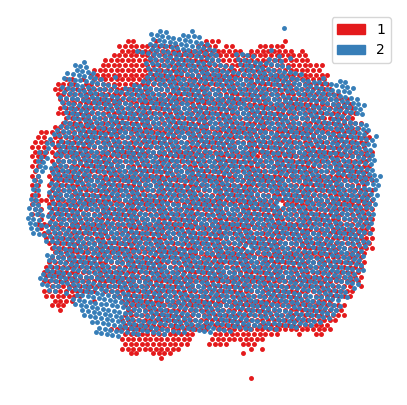

569.7206772312067
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


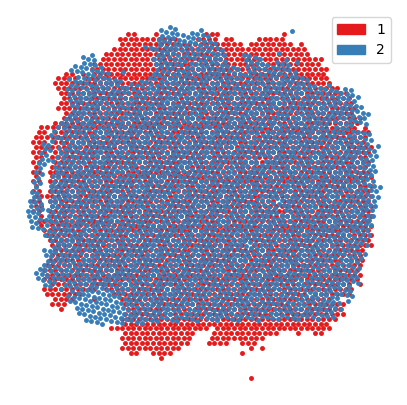

544.7577344049648
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


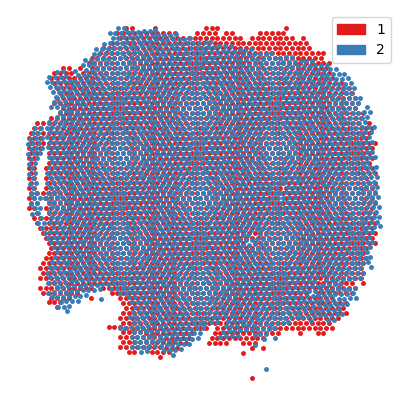

36.14330316796941
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


In [ ]:
batch_aligment(level)

## Highly noisy

In [17]:
level = 'highly'

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


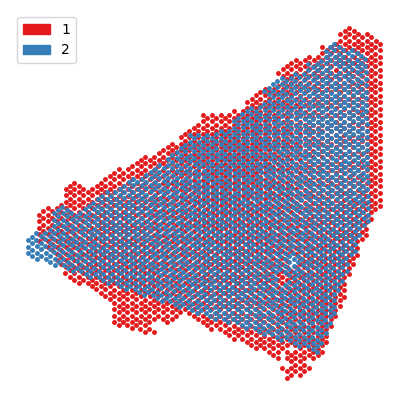

82.03801322234641


In [26]:
batch_aligment(level)

# Real Case

In [8]:
data_dir = '/condo/wanglab/shared/wxc/clip/data/human/ST_data/data12_Ovarian_Carcinosarcoma_4sample/'

In [11]:
target_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data.h5ad'
ad_tar = sc.read_h5ad(os.path.join(data_dir, target_sample_name))

In [12]:
sc.pp.filter_genes(ad_tar, min_counts = 15)
sc.pp.filter_cells(ad_tar, min_counts = 100)
del ad_tar.uns

In [14]:
src_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data.h5ad'
ad_src = sc.read_h5ad(os.path.join(data_dir, src_sample_name))
sc.pp.filter_genes(ad_src, min_counts = 15)
sc.pp.filter_cells(ad_src, min_counts = 100)
del ad_src.uns

In [15]:
pi12 = paste.pairwise_align(ad_tar, ad_src)

# To visualize the alignment you can stack the slices 
# according to the alignment pi
slices, pis = [ad_tar, ad_src], [pi12]
new_slices = paste.stack_slices_pairwise(slices, pis)

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


/condo/wanglab/hmaiwxc/anaconda3/envs/clip/lib/python3.9/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [16]:
save_path = '/condo/wanglab/shared/wxc/clip/data/human/ST_data/simulation_data/case_study/paste/'

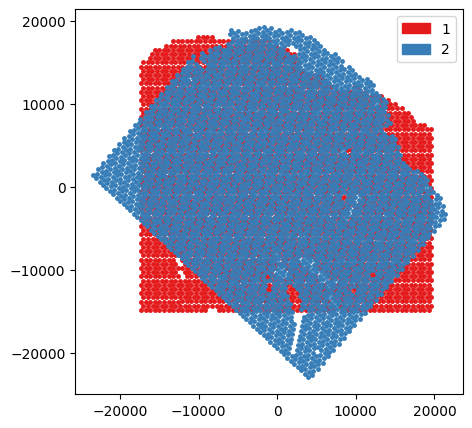

In [19]:
slice_colors = ['#e41a1c','#377eb8']
plt.figure(figsize=(5,5))
for i in range(len(new_slices)):
    paste.plot_slice(new_slices[i],slice_colors[i],s=50)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
# plt.gca().invert_yaxis()
# plt.axis('off')
plt.savefig(save_path+'paste_aligment.pdf')
plt.show()

In [20]:
new_slices[0].write_h5ad(save_path+'paste_aligment_target.h5ad')
new_slices[1].write_h5ad(save_path+'paste_aligment_source.h5ad')